In [2]:
from pathlib import Path

import pandas as pd 
import numpy as np
import xarray as xr
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (PROCESSED_GMT_FILE,
                           GRAPHICS_DIR, GRAPHICS_PAPER_MAIN_DIR, GRAPHICS_PAPER_APPENDIX_DIR, 
                           RESULTS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large, 
                           regions,
                           region_naming_dict, 
                           population_shares, 
                           group_colors,
                           uncertainty_color,
                           sensitvitiy_color,
                           symbols,
                           EU27_ids
                           )
from utils.plotting_functions import lighten_color

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cmaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.colors as cm

from tabulate import tabulate

from itertools import product

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
tas_intensity_df = xr.open_dataset(RESULTS_DIR / 'tas_intensity_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_intensity_df = xr.open_dataset(RESULTS_DIR / 'spei_intensity_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spi_intensity_df = xr.open_dataset(RESULTS_DIR / 'spi_intensity_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

ds_coords = tas_intensity_df['coords']

In [4]:
cmap_spi = LinearSegmentedColormap.from_list(
    "", ["#e6e1da", "#ba8057", "#4f2a1a"], gamma=0.8
)

cmap_tas = LinearSegmentedColormap.from_list(
    "", ["#f2dfd7", "#ff7733", "#8c0c0c"], gamma=0.8
)

In [9]:
import regionmask 
import matplotlib.patches as patches
ar6 = regionmask.defined_regions.ar6.land
gdf = ar6.to_geodataframe()
gdf = gdf.set_index("abbrevs")
density = 4

def data_peak_month(var, region, group, extreme_quantile, extreme_type):

    raw_df = xr.open_dataset(RESULTS_DIR / f'{var}_intensity_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

    idx_month = np.load(RESULTS_DIR / 'tas_hottest_month.npy')

    ttest = np.load(RESULTS_DIR / f'{var}_test_results_{region}_{group}_equal-scaling.npy')
    means = np.load(RESULTS_DIR / f'{var}_means_{region}_{group}_equal-scaling.npy')
    mask = (ttest > 0.05)

    df = raw_df.sel(region = region, extreme_quantile = extreme_quantile)

    # only keep locations with significant difference in distributions
    tmp = df[f'attributed_{var}'].values
    sel = np.array([tmp[:, :, idx, i] for i, idx in enumerate(idx_month)]).T

    plot_df = xr.DataArray(data = sel, 
                        dims = ['model', 'group', 'coords'], 
                        coords = {'group': df.group,'model': df.model, 'coords': df['coords']})

    z_mean = plot_df.sel(group = group).mean(dim = 'model').unstack('coords').sortby('lon').values.T
    z_std = plot_df.sel(group = group).std(dim = 'model').unstack('coords').sortby('lon').values.T
    z_mean[np.isnan(z_mean)] = 1000
    z_std[np.isnan(z_std)] = 0 
    # z_std[np.abs(z_mean) <= 0.1] = 1000
    # z_mean[~np.isfinite(z_mean)] = 0
    # z_std[~np.isfinite(z_std)] = 0
    sel[sel < 0] = 0

    plot_df = xr.DataArray(data = sel, 
                        dims = ['model','group', 'coords'], 
                        coords = {'group': df.group, 'model': df.model, 'coords': df['coords']}).median(dim = 'model').unstack('coords').sortby('lon')
    
    return(plot_df, z_mean, z_std)

def data_month(var, month, region, group, extreme_quantile, extreme_type):

    raw_df = xr.open_dataset(RESULTS_DIR / f'{var}_intensity_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')

    ttest = np.load(RESULTS_DIR / f'{var}_test_results_{region}_{group}_equal-scaling.npy')
    means = np.load(RESULTS_DIR / f'{var}_means_{region}_{group}_equal-scaling.npy')
    mask = (ttest > 0.05)

    df = raw_df.sel(region = region, extreme_quantile = extreme_quantile, month = month)

    # only keep locations with significant difference in distributions
    tmp = df[f'attributed_{var}'].values
    
    plot_df = xr.DataArray(data = tmp, 
                        dims = ['group', 'model', 'coords'], 
                        coords = {'group': df.group,'model': df.model, 'coords': df['coords']})

    z_mean = plot_df.sel(group = group).mean(dim = 'model').unstack('coords').sortby('lon').values.T
    z_std = plot_df.sel(group = group).std(dim = 'model').unstack('coords').sortby('lon').values.T
    z_mean[np.isnan(z_mean)] = 1000
    z_std[np.isnan(z_std)] = 0 
    # z_std[np.abs(z_mean) <= 0.1] = 1000
    # z_mean[~np.isfinite(z_mean)] = 0
    # z_std[~np.isfinite(z_std)] = 0
    tmp[tmp < 0] = 0

    plot_df = xr.DataArray(data = tmp, 
                        dims = ['group', 'model', 'coords'], 
                        coords = {'group': df.group, 'model': df.model, 'coords': df['coords']}).median(dim = 'model').unstack('coords').sortby('lon')
    
    return(plot_df, z_mean, z_std)

def plot_1D_colorbar(ax, cmap, bins, bin_labels, indicator_label = 'Additional occurences [#]'):
    N_bins = len(bins)-1
    cmap_binned = cmap(np.linspace(0, 1, N_bins))
    ax.imshow(np.array(cmap_binned).reshape(-1, N_bins, 4), origin='lower', extent = [-0.5, N_bins-0.5, 0, 0.6])
    ax.set_xlabel(indicator_label, fontsize = fontsize_medium)
    # ax.set_ylabel('Potential drought [#]', fontsize = fontsize_medium)
    ax.set_xticks(np.arange(N_bins)-0.5, bin_labels, fontsize = fontsize_medium)
    ax.set_yticks([], [])
    return()

def plot_map(ax, plot_df, z_mean, z_std, bins, cmap, sel_regions, title = '', density = 4, amazon = False):
    lons = plot_df.lon.values
    lats = plot_df.lat.values

    ax.set_global()
    ax.coastlines(edgecolor = 'lightgrey')

    contour = ax.contourf(
        lons, lats, (z_mean.T <= z_std.T)*1,
        transform = ccrs.PlateCarree(),
        colors = 'none',
        levels=[.5,1.5],
        hatches=[density*'/',density*'/'], 
        zorder = 10
    )

    plot_df.plot(ax=ax, 
                transform = ccrs.PlateCarree(),
                cmap = cmap,
                levels  = bins,
                add_colorbar = False,
                extend = 'neither',
                alpha = None
                )
    if amazon == False: 
        for abbrev in [ar6[region].abbrev for region in sel_regions]: 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 1.5)        
    elif amazon == True: 
        for abbrev in [ar6[region].abbrev for region in sel_regions if not region in [9, 10,11,12]]: 
            gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 1.5)  
        abbrevs_amazon = [ar6[region].abbrev for region in [9, 10,11,12]]
        polygon_amazon = gdf.loc[abbrevs_amazon].unary_union
        amazon_gdf = gpd.GeoDataFrame(geometry=[polygon_amazon], crs=gdf.crs)
        amazon_gdf.plot(ax=ax, transform=ccrs.PlateCarree(), 
                                facecolor='none', 
                                edgecolor = 'black', 
                                lw = 1.5)
    
    ax.set_title(title, fontsize = fontsize_large)
    return()

def data_for_regional_bargraph(var, extreme_type, extreme_quantile, month = 'peak', amazon = False):
    raw_df = xr.open_dataset(RESULTS_DIR / f'{var}_intensity_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
    
    vars = [f'attributed_{var}', f'1990_{var}', f'presentday_{var}']
    datasets = []
    if month == 'peak': 
        idx_month = np.load(RESULTS_DIR / f'tas_hottest_month.npy')
        for var in vars: 
            df = raw_df.sel(extreme_quantile = extreme_quantile, region = 'World')
            if 'attributed' in var:
                sel = np.array([df[var][:, :, idx, i] for i, idx in enumerate(idx_month)]).T
                z_mean = np.nanmean(sel[:, 0, :], axis = 0)
                z_std =  np.nanstd(sel[:, 0, :], axis = 0)
                sel = np.array([sel[:, 0, :], sel[:, 1, :]])
                # sel[:, :, z_mean < z_std] = np.NaN
                
            else: 
                sel = np.array([df[var][:, idx, i] for i, idx in enumerate(idx_month)]).T
                # z_mean = np.nanmean(sel, axis = 1)
                # z_std =  np.nanstd(sel, axis = 1)
                # sel[:, z_mean < z_std] = np.NaN

            datasets.append(sel)
    else: 
        for var in vars: 
            df = raw_df.sel(extreme_quantile = extreme_quantile, region = 'World', month = month)
            if 'attributed' in var:
                sel = df[var].values
                z_mean = np.nanmean(sel[0, :, :], axis = 0)
                z_std =  np.nanstd(sel[0, :, :], axis = 0)
                # sel[:, :, z_mean < z_std] = np.NaN
            else: 
                sel = df[var].values
                # z_mean = np.nanmean(sel, axis = 1)
                # z_std =  np.nanstd(sel, axis = 1)
                # sel[:, z_mean < z_std] = np.NaN

            datasets.append(sel)        
        
    df = xr.Dataset(data_vars = {vars[0]: (('group', 'model', 'coords'), datasets[0]), 
                                vars[1]: (('model', 'coords'), datasets[1]),
                                vars[2]: (('model', 'coords'), datasets[2])
                                },
                    coords = {'coords': raw_df['coords'], 
                            'group':  raw_df['group'], 
                            'model':  raw_df['model']
                            }
        )

    mask = ar6.mask(df)
    weights = np.cos(np.deg2rad(df.lat))
    weights.name = "weights"
    
    if amazon == True: 
        mask[(mask == 12) | (mask == 10) | (mask == 9)] = 11
    
    df_agg = (df).groupby(mask).median('coords')
    df_glob = (df).median('coords').expand_dims(mask = [45])

    return(xr.concat([df_agg, df_glob], dim = 'mask'))

def regional_bargraph_plot(sel_var, extreme_type, extreme_quantile, sel_regions, ylabel, yticks, yticklabels, xticks, xticklabels, title, ax, legend = False, month = 'peak', amazon = False, nodata = False, regions_to_zero = None): 
    df_agg = data_for_regional_bargraph(sel_var, extreme_type, extreme_quantile, month = month, amazon = amazon)
    
    if regions_to_zero is not None:
        for region_id in regions_to_zero: 
            idx = np.argwhere(df_agg.mask.values == region_id)[0][0] 
            df_agg[f'attributed_{sel_var}'][idx, :, :] = 0
            df_agg[f'1990_{sel_var}'][idx, :] = 0
            df_agg[f'presentday_{sel_var}'][idx, :] = 0
    
    
    if sel_var == 'spi': 
        df_agg[f'attributed_{sel_var}'][-1, :, :] = 0
        df_agg[f'1990_{sel_var}'][-1, :] = 0
        df_agg[f'presentday_{sel_var}'][-1, :] = 0
        
    sel_regions  = [45] + sel_regions
    
    n_regions = len(sel_regions)
    bottoms = np.array([0]*n_regions)
    positions = np.arange(n_regions)
    
    xticks = positions
    xticklabels = ['World'] + xticklabels
    
    group_colors_dark = [lighten_color(color, 1.5) for color in group_colors]

    var_names = [f'attributed_{sel_var}', f'attributed_{sel_var}', f'1990_{sel_var}']
    groups = ['p99p100', 'p90p100', 'p90p100']

    if nodata == False: 
        bars = []
        for i_stack in range(3): 
            bar = ax.bar(positions, 
                df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model').values-bottoms, 
                bottom = bottoms, 
                color = group_colors[2-i_stack])
            bottoms = df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model')
            for i_region, region in enumerate(sel_regions): 
                if not ((region == 45) & (sel_var == 'spi')):
                    line, = ax.plot([positions[i_region], positions[i_region]], 
                            np.nanquantile(df_agg.sel(group = groups[i_stack], mask = region)[var_names[i_stack]].values, q = [0.05,0.95]), 
                            marker = '_',
                            lw = 0.5,
                            color = group_colors_dark[2-i_stack])   
            bars.append(bar)
        
        line, = ax.plot([0,0.001], [0,0.001], lw = 1, color = 'black')
            
        group_sizes = [0.01,0.1]

        width = 0.25
        for i_region, region in enumerate(sel_regions):
            height = df_agg.sel(group = groups[i_stack], mask = region)[var_names[2]].median('model')
            for i_top in range(2): 
                count_i_top = df_agg.sel(group = groups[i_top], mask = region)[var_names[i_top]].median('model')
                ratio = np.round(count_i_top/height*1/group_sizes[i_top], 1)
                if not ((np.isnan(ratio)) or (ratio < 0.5)):            
                    ax.text(x = i_region+width*1.2-2*(i_top)*width*1.05, 
                            y = height, 
                            s = f'{ratio:.1f}',
                            ha='center', 
                            va='bottom', 
                            fontsize = fontsize_medium,
                            weight = 'bold', 
                            color = group_colors[2-i_top]
                            )
        if legend == True: 
            ax.legend([bars[0][0], bars[1][0], bars[2][0], line], ['Top 1%', 'Top 10%', 'Since 1990', '5-95% quantile'], 
                    fontsize = fontsize_medium,
                    bbox_to_anchor = (0.43, 1.2),
                    loc = 'upper left',
                    facecolor = (1,1,1,.7),
                    edgecolor = 'none',
                    ncols = 2,
                    columnspacing=0.8,
                    handletextpad=0.3
                        )
    else:
        ax.plot()

    ax.set_title(title, fontsize = fontsize_large)
    ax.set_xticks(xticks,
                  xticklabels, 
                  fontsize  = fontsize_medium, 
                  rotation  = 45)
    ax.set_yticks(yticks, 
                  yticklabels,
                  fontsize = fontsize_medium)
    ax.set_ylabel(ylabel, fontsize = fontsize_medium)
    ax.set_ylim(bottom = 0)    
    return()

def get_boxplot_data(var, extreme_type, region):
    raw_df = xr.open_dataset(RESULTS_DIR / f'{var}_intensity_{extreme_type}.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
    if region == 'World': 
        boxplot_data = raw_df[f'attributed_{var}'].isel(region = 0, group = 0, extreme_quantile = 1).median(dim = 'model').values
    if region == 'Amazon': 
        mask = ar6.mask(raw_df)    
        weights = np.cos(np.deg2rad(raw_df.lat))
        weights.name = "weights"
        mask[(mask == 12) | (mask == 10) | (mask == 9)] = 11
        boxplot_data = raw_df[f'attributed_{var}'].isel(region = 0, group = 0, extreme_quantile = 1)[:, :, mask == 11].median(dim = 'model').values
    boxplot_data[boxplot_data < 0] = 0
    return(boxplot_data)

def make_boxplot(ax, boxplot_data, cmap, cmap_levels, y_ticks, y_tick_labels, title, width = 0.35, nodata = False):
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if nodata == False: 
        medians = np.median(boxplot_data, axis = 1)
        norm = cm.BoundaryNorm(cmap_levels, cmap.N)

        # Get colors for each median value
        colors = [cmap(norm(value)) for value in medians]


        # colors = cmap(np.linspace(0, 1, 12))
        bplot = ax.boxplot(boxplot_data.T,
                            positions = np.arange(0,12),
                            widths  = width,
                            notch = True, 
                            patch_artist = True
                            )

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bplot[element], color='black')  
    if nodata == True: 
        ax.plot()
        # ax.legend([bplots[0]['boxes'][6], bplots[1]['boxes'][6]],
        #             ['Heat', 'Potential drought'], 
        #             fontsize = fontsize_medium,
        #             facecolor = (1,1,1,.7),
        #             edgecolor = 'none',
        #             loc = 'upper right')
    ax.set_xlim(-1, 12)
    ax.set_xticks(np.arange(0,12), month_abbr, fontsize  = fontsize_medium)
    ax.set_yticks(y_ticks,
                y_tick_labels,
                fontsize  = fontsize_medium)
    ax.set_title(title,
                    fontsize = fontsize_large)   
    ax.set_ylabel('Additional \n occurrences [#]',        
                    fontsize = fontsize_medium)       
    return()

In [37]:
df_agg = data_for_regional_bargraph('tas', 'hot', 0.99, month = 7, amazon = True)

In [10]:
tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


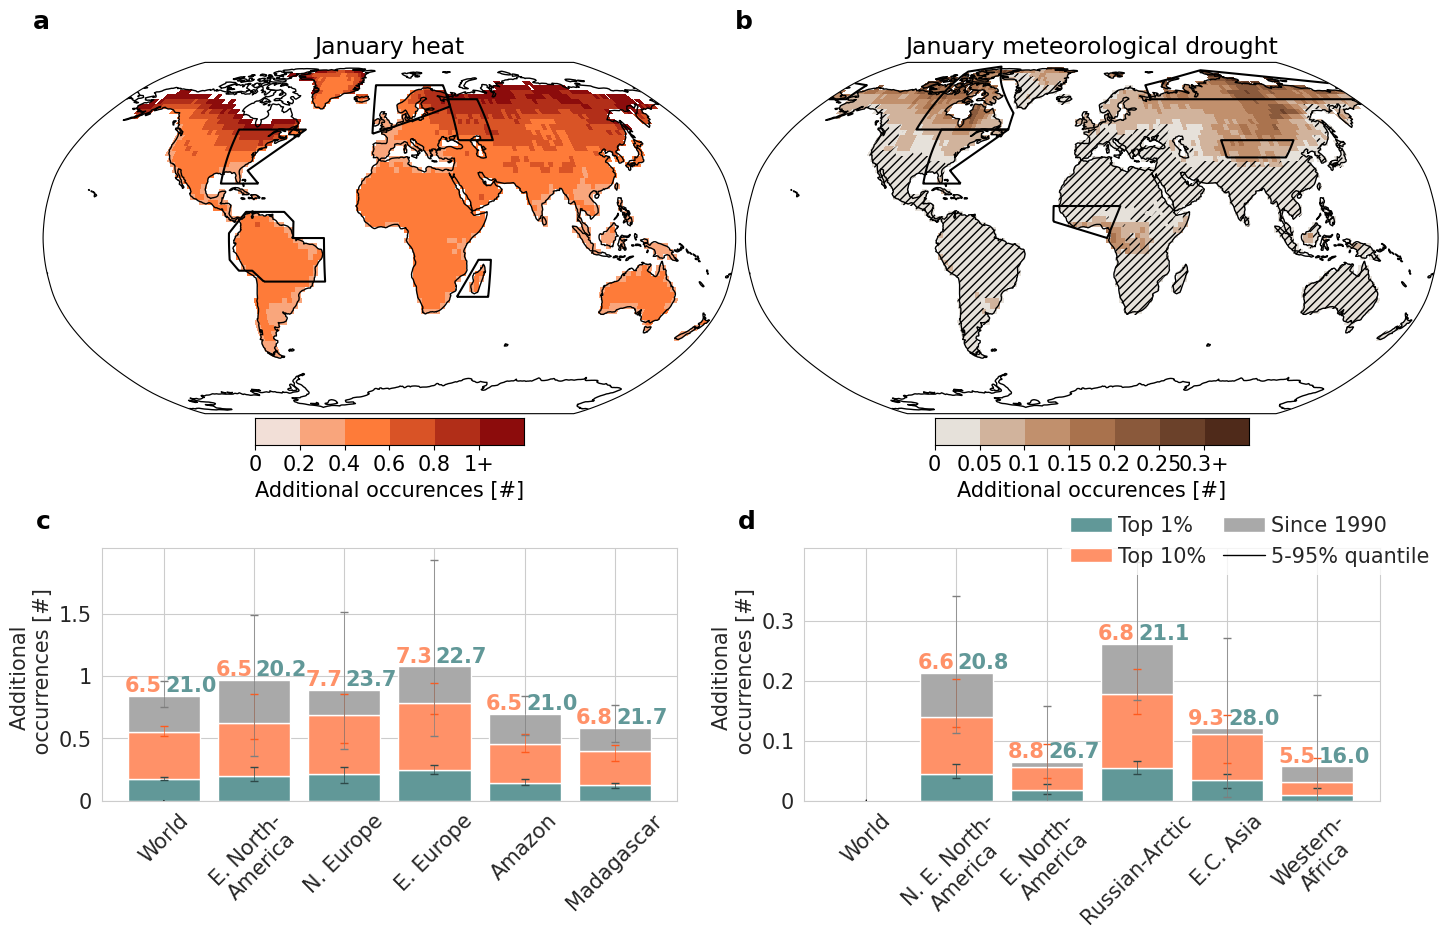

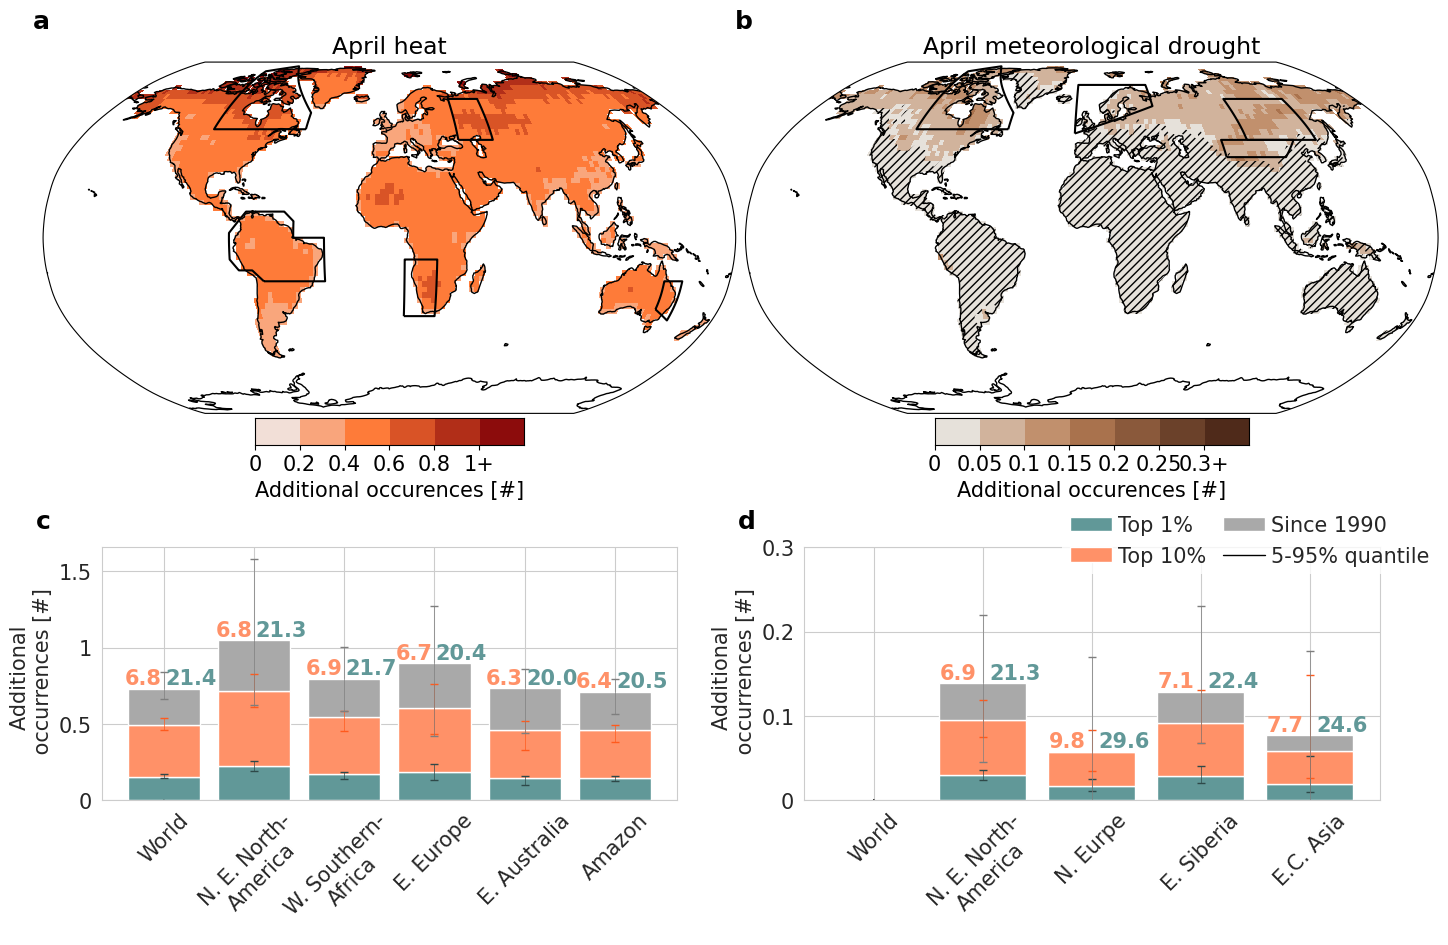

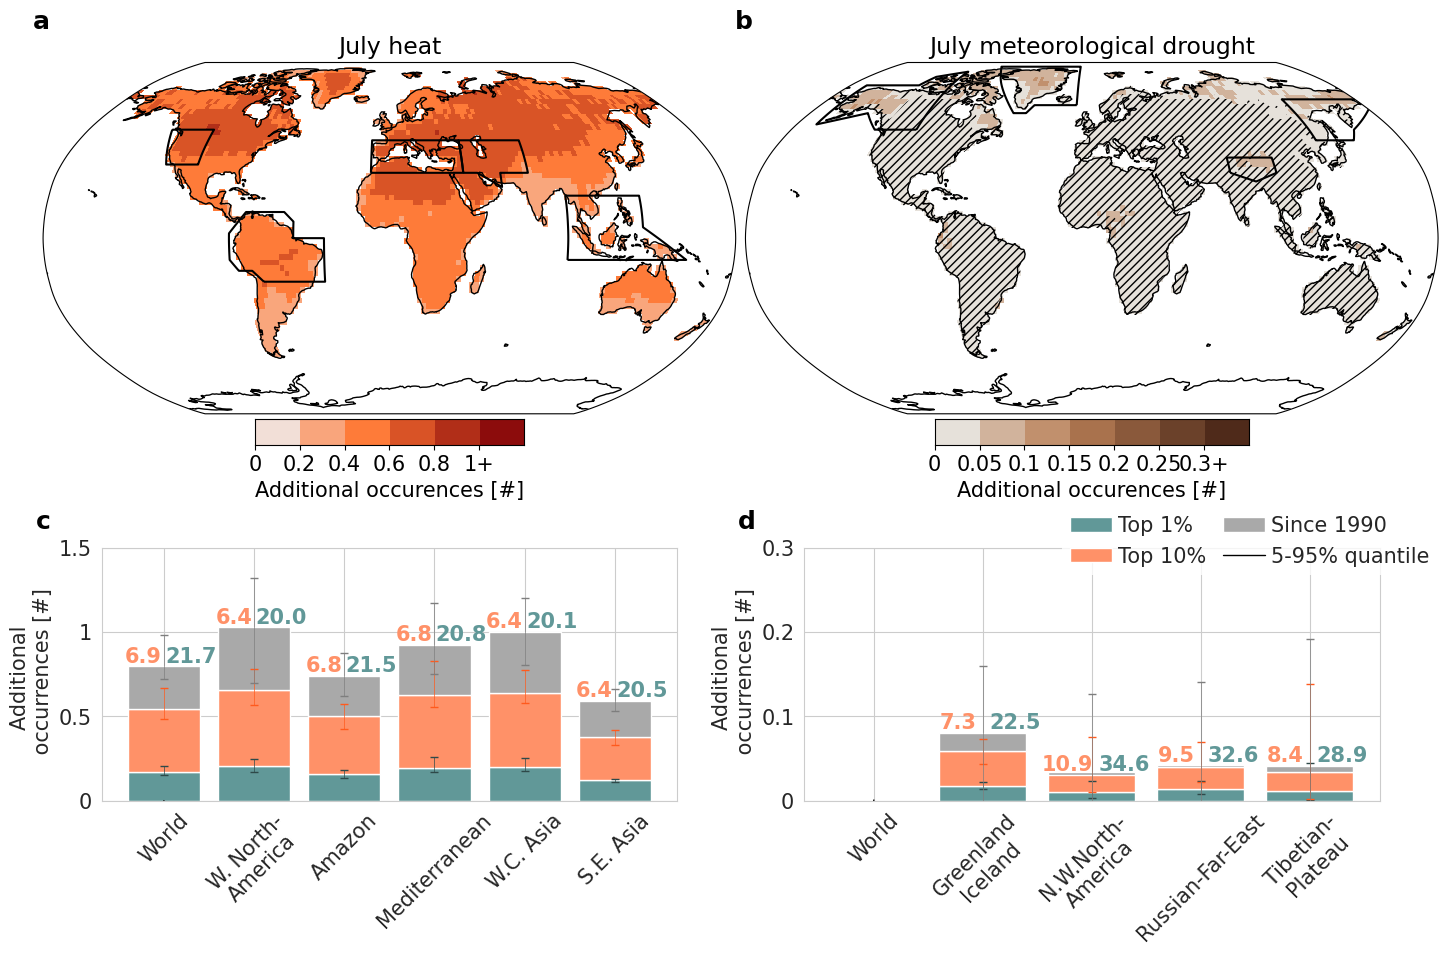

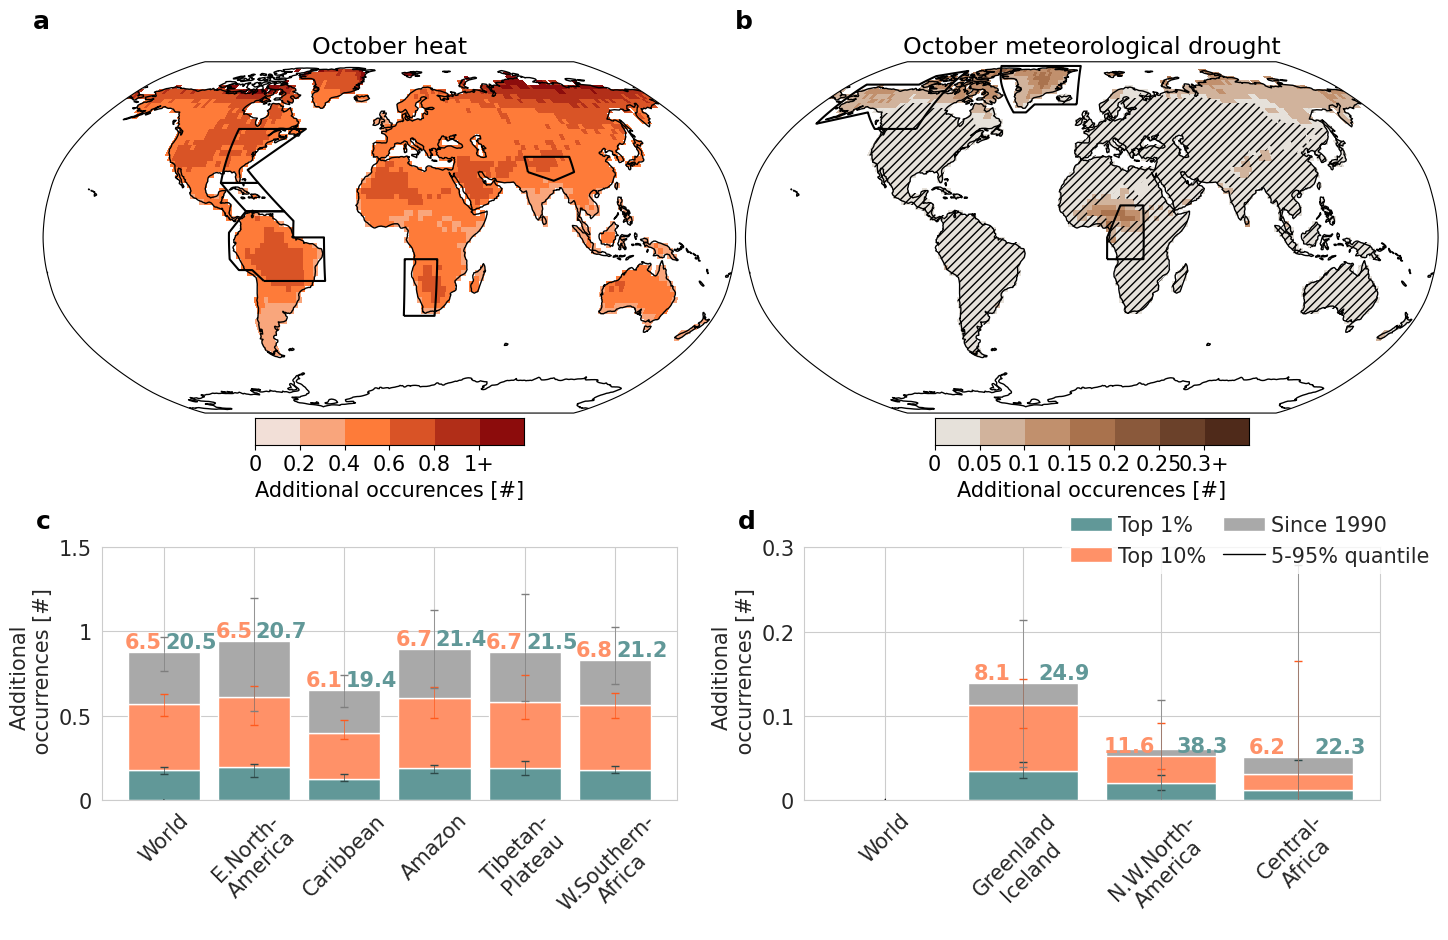

In [40]:
# make full data: 
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sel_regions = [7, 11, 19, 25, 38]

all_sell_regions_tas = [
    [5,16,18,11,27], 
    [2,25,18,41,11], 
    [3,11,19,32,38],
    [5,8,11,34,25]
]
all_sell_regions_spi = [
    [2,5,28,33,21], 
    [2,16,30,33], 
    [0,1,31,34], 
    [0,1,22]
]

all_region_names_tas = [
    ['E. North-\nAmerica', 'N. Europe', 'E. Europe', 'Amazon', 'Madagascar'],
    ['N. E. North-\nAmerica', 'W. Southern-\nAfrica', 'E. Europe', 'E. Australia', 'Amazon'],
    ['W. North-\nAmerica', 'Amazon', 'Mediterranean', 'W.C. Asia', 'S.E. Asia'],
    ['E.North-\nAmerica', 'Caribbean', 'Amazon', 'Tibetan-\nPlateau', 'W.Southern-\nAfrica'],
]
all_region_names_spi = [
    ['N. E. North-\nAmerica', 'E. North-\nAmerica', 'Russian-Arctic', 'E.C. Asia', 'Western-\nAfrica'],
    ['N. E. North-\nAmerica', 'N. Eurpe', 'E. Siberia', 'E.C. Asia'],
    ['Greenland\nIceland', 'N.W.North-\nAmerica', 'Russian-Far-East', 'Tibetian-\nPlateau'],
    ['Greenland\nIceland', 'N.W.North-\nAmerica', 'Central-\nAfrica'],
]

all_regions_to_zero = [
    [45], 
    [45],
    [45], 
    [45]
]

for i, month in enumerate([0,3,6,9]):
    sel_regions_tas = all_sell_regions_tas[i]
    sel_region_names_tas = all_region_names_tas[i]
    sel_regions_spi = all_sell_regions_spi[i]
    sel_region_names_spi = all_region_names_spi[i]    
    
    regions_to_zero = all_regions_to_zero[i]

    n_regions = len(sel_regions_tas)
    
    spi_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    spi_bin_labels = ['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3+']
    spi_y_ticks = [0,0.1,0.2,0.3]
    spi_y_tick_labels = [0,0.1,0.2,0.3]
    tas_bins = [0,0.2,0.4,0.6,0.8, 1, 1.2]
    tas_bin_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1+']
    tas_y_ticks = [0,0.5,1,1.5]
    tas_y_tick_labels = [0,0.5,1,1.5]
    

    indicator_label = 'Additional occurences [#]'

    fig = plt.figure(figsize= (18, 10))
    gs  = GridSpec(24, 24, figure=fig)

    axes = []
    ax = fig.add_subplot(gs[:13, :12], projection=ccrs.Robinson())
    cbar_ax = fig.add_subplot(gs[12:13, :12])
    plot_df, z_mean, z_std = data_month('tas', month, 'World', 'p90p100', 0.99, 'hot')
    plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, tas_bins, cmap_tas, sel_regions_tas, title = f'{month_names[month]} heat', density = 4, amazon = True)
    plot_1D_colorbar(cbar_ax, cmap_tas, tas_bins, tas_bin_labels)
    axes.append(ax)

    ax = fig.add_subplot(gs[:13, 12:], projection=ccrs.Robinson())
    cbar_ax = fig.add_subplot(gs[12:13, 12:])
    plot_df, z_mean, z_std = data_month('spi', month, 'World', 'p90p100', 0.01, 'dry')
    plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, spi_bins, cmap_spi, sel_regions_spi, title = f'{month_names[month]} meteorological drought', density = 4, amazon = False)
    plot_1D_colorbar(cbar_ax, cmap_spi, spi_bins, spi_bin_labels)
    axes.append(ax)

    with sns.axes_style('whitegrid'):
        ax = fig.add_subplot(gs[16:, 1:11])
        regional_bargraph_plot('tas', 'hot', 0.99, sel_regions_tas, 'Additional \n occurrences [#]', tas_y_ticks, tas_y_tick_labels, np.arange(len(sel_regions)), sel_region_names_tas, '', ax, legend = False, amazon = True, month = month)
        axes.append(ax)

        ax = fig.add_subplot(gs[16:, 13:23])
        regional_bargraph_plot('spi', 'dry', 0.01, sel_regions_spi, 'Additional \n occurrences [#]', spi_y_ticks, spi_y_tick_labels, np.arange(len(sel_regions)), sel_region_names_spi, '', ax, legend = True, amazon = False, month = month, regions_to_zero = regions_to_zero)
        axes.append(ax)

    lettering = ['a', 'b', 'c', 'd']

    xs = [-0.015]*2 + [-0.115]*2
    ys = [1.15]*4
    for i, ax in enumerate(axes):
            ax.text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

    Path(GRAPHICS_PAPER_APPENDIX_DIR).mkdir(parents=True, exist_ok=True)
    plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / f'{month_names[month]}_1-in-100year_intensity-change.pdf', bbox_inches = 'tight', dpi = 600)

    plt.show()

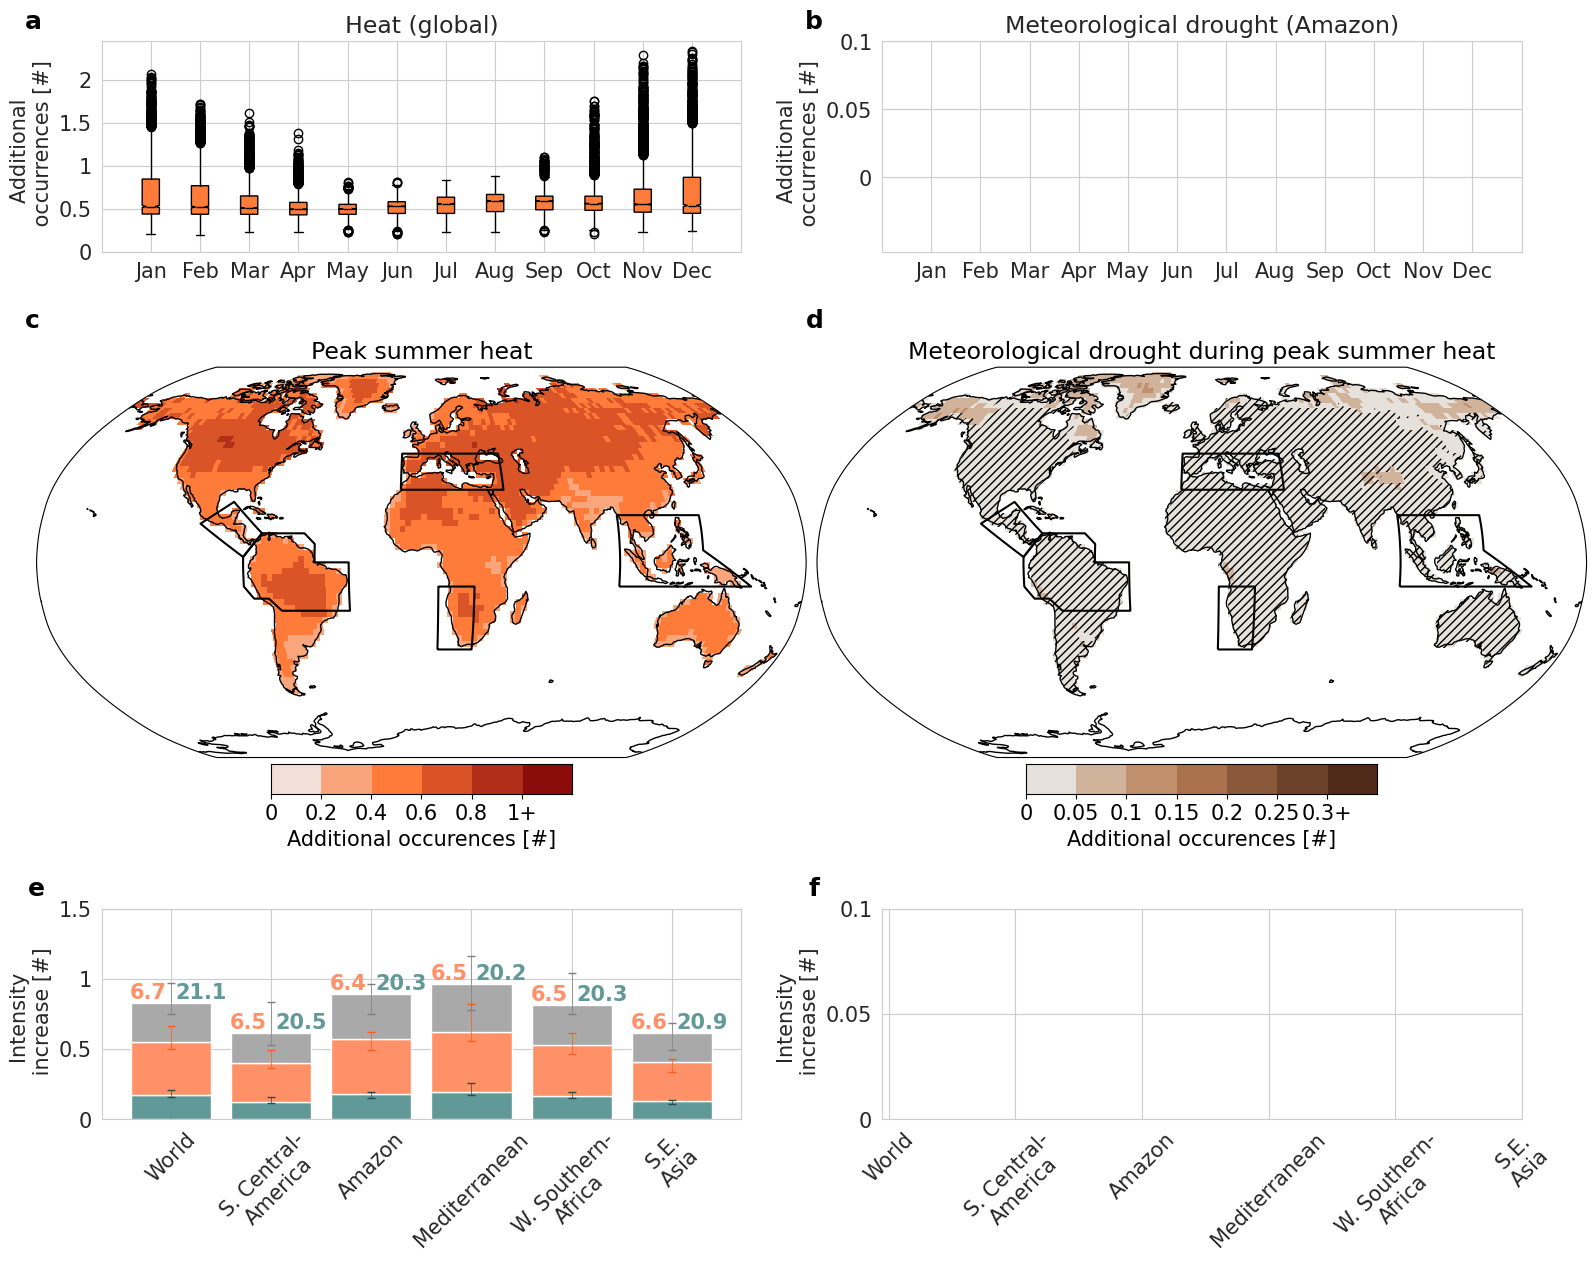

In [47]:
# make full data: 
sel_regions = [7, 11, 19, 25, 38]
n_regions = len(sel_regions)
region_names = [ar6[region].abbrev for region in sel_regions]
region_names_long = [ar6[region].name for region in sel_regions]
region_names_sep = ['S. Central-\nAmerica',
                    'Amazon',
                    'Mediterranean',
                    'W. Southern-\nAfrica',
                    'S.E.\nAsia'
                    ]

spi_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
spi_bin_labels = ['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3+']
spi_y_ticks = [0,0.05,0.1]
spi_y_tick_labels = [0,0.05,0.1]
tas_bins = [0,0.2,0.4,0.6,0.8, 1, 1.2]
tas_bin_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1+']
tas_y_ticks = [0,0.5,1,1.5,2]
tas_y_tick_labels = [0,0.5,1,1.5,2]

indicator_label = 'Additional occurences [#]'

fig = plt.figure(figsize= (20, 14))
gs  = GridSpec(30, 24, figure=fig)

axes = []
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[:6, 1:11])
    tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
    make_boxplot(ax, 
                tas_boxplot_data, 
                cmap_tas, 
                tas_bins, 
                tas_y_ticks, 
                tas_y_tick_labels, 
                'Heat (global)'
                )
    axes.append(ax)

    ax = fig.add_subplot(gs[:6, 13:23])
    #ax.plot()
    spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')
    make_boxplot(ax, 
                spi_boxplot_data, 
                cmap_spi, 
                spi_bins, 
                spi_y_ticks, 
                spi_y_tick_labels, 
                'Meteorological drought (Amazon)',
                nodata = True,
                )
    # ax.set_xticks([], [])
    # ax.set_yticks([], [])
    axes.append(ax)

ax = fig.add_subplot(gs[5:24, :12], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[20:21, :12])
plot_df, z_mean, z_std = data_peak_month('tas', 'World', 'p90p100', 0.99, 'hot')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, tas_bins, cmap_tas, sel_regions, title = 'Peak summer heat', density = 4, amazon = True)
plot_1D_colorbar(cbar_ax, cmap_tas, tas_bins, tas_bin_labels)
axes.append(ax)

ax = fig.add_subplot(gs[5:24, 12:], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[20:21, 12:])
plot_df, z_mean, z_std = data_peak_month('spi', 'World', 'p90p100', 0.01, 'dry')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, spi_bins, cmap_spi, sel_regions, title = 'Meteorological drought during peak summer heat', density = 4, amazon = True)
plot_1D_colorbar(cbar_ax, cmap_spi, spi_bins, spi_bin_labels)
axes.append(ax)

with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[24:, 1:11])
    regional_bargraph_plot('tas', 'hot', 0.99, sel_regions, 'Intensity \n increase [#]', tas_y_ticks[:-1], tas_y_tick_labels[:-1], np.arange(len(sel_regions)), region_names_sep, '', ax, legend = False, amazon = True)
    axes.append(ax)

    ax = fig.add_subplot(gs[24:, 13:23])
    regional_bargraph_plot('spi', 'dry', 0.01, sel_regions, 'Intensity \n increase [#]', spi_y_ticks ,spi_y_tick_labels, np.arange(len(sel_regions)), region_names_sep, '', ax, legend = True, amazon = True, nodata = True)
    axes.append(ax)

lettering = ['a', 'b', 'c', 'd', 'e', 'f']

xs = [-0.12]*2 + [-0.015]*2 + [-0.115]*2
ys = [1.15]*6
for i, ax in enumerate(axes):
        ax.text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

Path(GRAPHICS_PAPER_APPENDIX_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'intensity_1in100years_peak_summer_heat.pdf', bbox_inches = 'tight', dpi = 600)

plt.show()

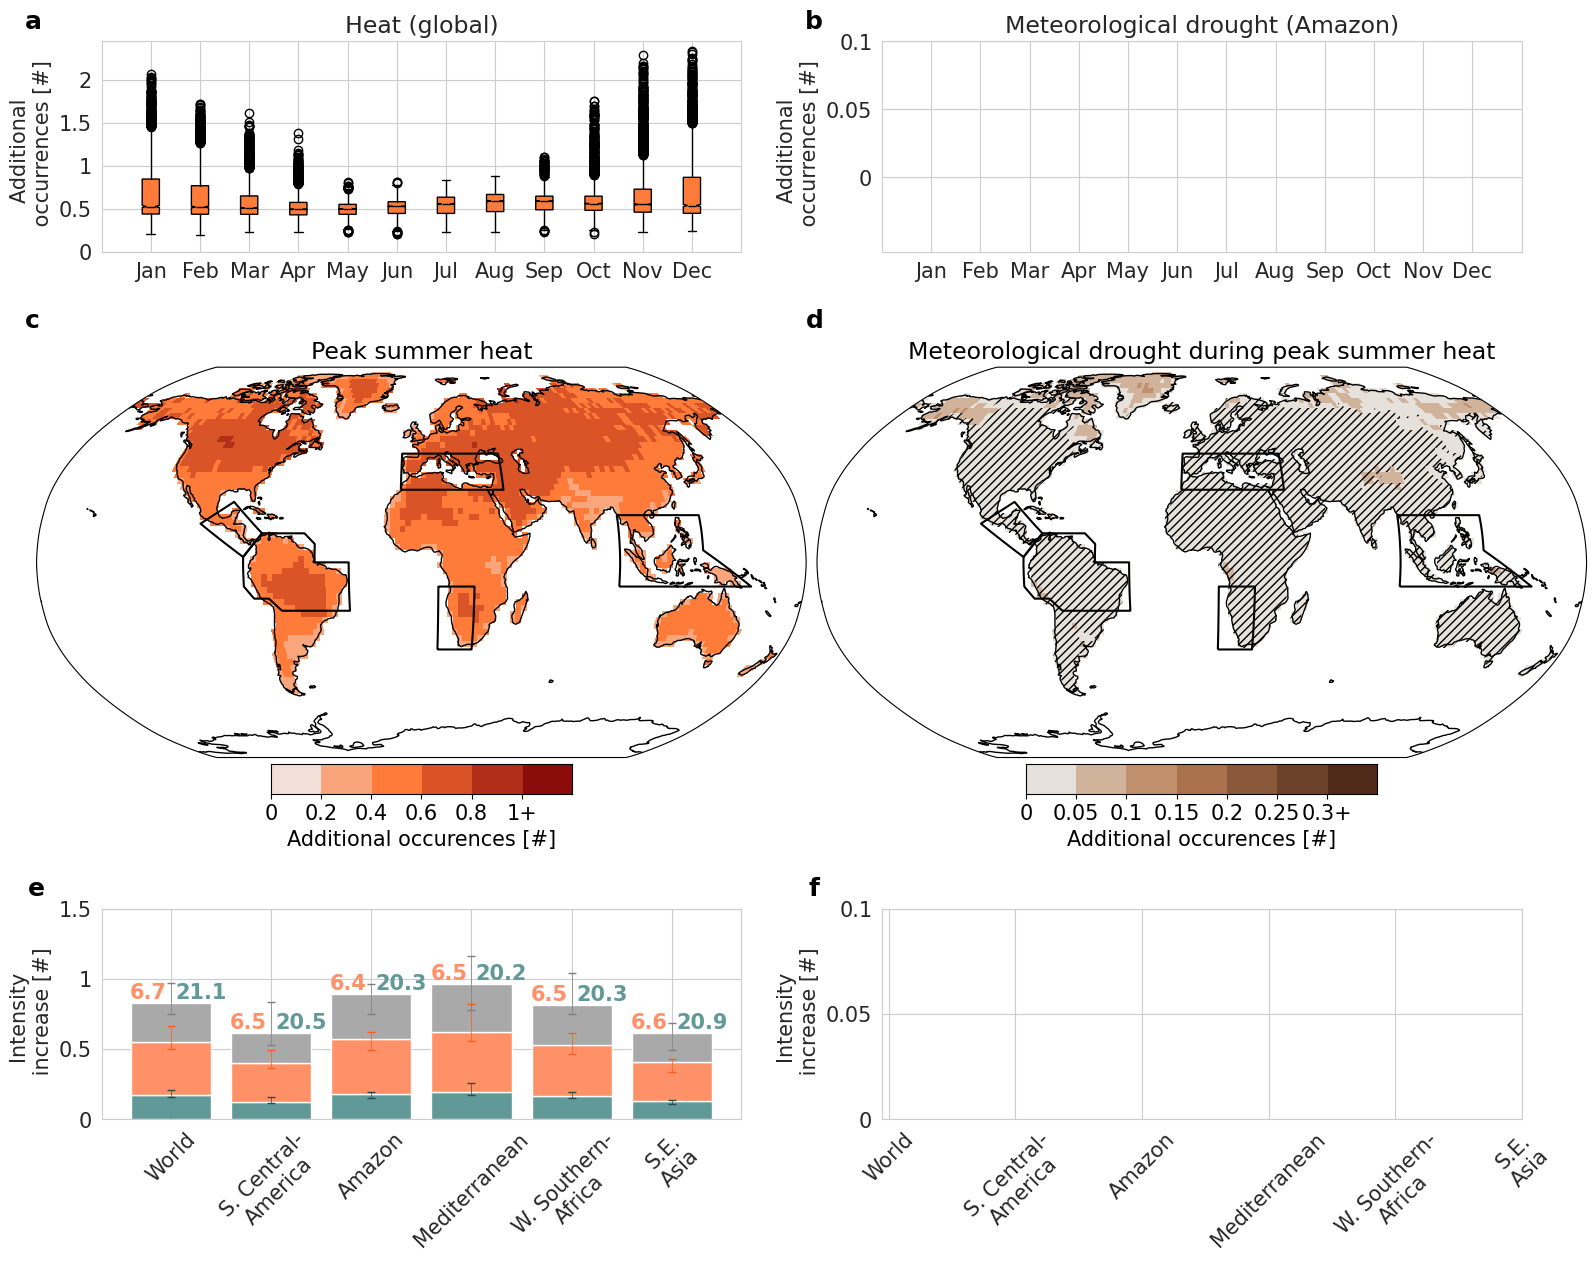

In [ ]:
# make full data: 
sel_regions = [7, 11, 19, 25, 38]
n_regions = len(sel_regions)
region_names = [ar6[region].abbrev for region in sel_regions]
region_names_long = [ar6[region].name for region in sel_regions]
region_names_sep = ['S. Central-\nAmerica',
                    'Amazon',
                    'Mediterranean',
                    'W. Southern-\nAfrica',
                    'S.E.\nAsia'
                    ]

spi_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
spi_bin_labels = ['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3+']
spi_y_ticks = [0,0.05,0.1]
spi_y_tick_labels = [0,0.05,0.1]
tas_bins = [0,0.2,0.4,0.6,0.8, 1, 1.2]
tas_bin_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1+']
tas_y_ticks = [0,0.5,1,1.5,2]
tas_y_tick_labels = [0,0.5,1,1.5,2]

indicator_label = 'Additional occurences [#]'

fig = plt.figure(figsize= (20, 14))
gs  = GridSpec(30, 24, figure=fig)

axes = []
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[:6, 1:11])
    tas_boxplot_data = get_boxplot_data('tas', 'hot', 'World')
    make_boxplot(ax, 
                tas_boxplot_data, 
                cmap_tas, 
                tas_bins, 
                tas_y_ticks, 
                tas_y_tick_labels, 
                'Heat (global)'
                )
    axes.append(ax)

    ax = fig.add_subplot(gs[:6, 13:23])
    #ax.plot()
    spi_boxplot_data = get_boxplot_data('spi', 'dry', 'Amazon')
    make_boxplot(ax, 
                spi_boxplot_data, 
                cmap_spi, 
                spi_bins, 
                spi_y_ticks, 
                spi_y_tick_labels, 
                'Meteorological drought (Amazon)',
                nodata = True,
                )
    # ax.set_xticks([], [])
    # ax.set_yticks([], [])
    axes.append(ax)

ax = fig.add_subplot(gs[5:24, :12], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[20:21, :12])
plot_df, z_mean, z_std = data_peak_month('tas', 'World', 'p90p100', 0.99, 'hot')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, tas_bins, cmap_tas, sel_regions, title = 'Peak summer heat', density = 4, amazon = True)
plot_1D_colorbar(cbar_ax, cmap_tas, tas_bins, tas_bin_labels)
axes.append(ax)

ax = fig.add_subplot(gs[5:24, 12:], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[20:21, 12:])
plot_df, z_mean, z_std = data_peak_month('spi', 'World', 'p90p100', 0.01, 'dry')
plot_map(ax, plot_df.sel(group = 'p90p100'), z_mean, z_std, spi_bins, cmap_spi, sel_regions, title = 'Meteorological drought during peak summer heat', density = 4, amazon = True)
plot_1D_colorbar(cbar_ax, cmap_spi, spi_bins, spi_bin_labels)
axes.append(ax)

with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(gs[24:, 1:11])
    regional_bargraph_plot('tas', 'hot', 0.99, sel_regions, 'Intensity \n increase [#]', tas_y_ticks[:-1], tas_y_tick_labels[:-1], np.arange(len(sel_regions)), region_names_sep, '', ax, legend = False, amazon = True)
    axes.append(ax)

    ax = fig.add_subplot(gs[24:, 13:23])
    regional_bargraph_plot('spi', 'dry', 0.01, sel_regions, 'Intensity \n increase [#]', spi_y_ticks ,spi_y_tick_labels, np.arange(len(sel_regions)), region_names_sep, '', ax, legend = True, amazon = True, nodata = True)
    axes.append(ax)

lettering = ['a', 'b', 'c', 'd', 'e', 'f']

xs = [-0.12]*2 + [-0.015]*2 + [-0.115]*2
ys = [1.15]*6
for i, ax in enumerate(axes):
        ax.text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')

Path(GRAPHICS_PAPER_APPENDIX_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'intensity_1in100years_peak_summer_heat.pdf', bbox_inches = 'tight', dpi = 600)

plt.show()

### Appendix

In [19]:

# colors = ["royalblue", "dodgerblue", "teal", 'seagreen', 'gold', 'darkorange', 'lightcoral', 'indianred', 'crimson', 'darkmagenta', 'darkviolet', 'mediumslateblue']

colors = [
    "#1f77b4",  # Blue
    "#2ca02c",  # Green
    "#ffcc00",  # Yellow
    "#ff7f0e",  # Orange
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#1f77b4"   # Back to Blue (to close the cycle)
]
colors = [
    "#336699",  # Muted Deep Blue
    "#488f31",  # Earthy Green
    "#d9ad3c",  # Warm Golden Yellow
    "#d07c40",  # Muted Orange
    "#b33a3a",  # Deep Red
    "#7a4e9e",  # Soft Plum Purple
    "#1f77b4"   # Back to Muted Deep Blue (closing the cycle)
]

cmap_months = LinearSegmentedColormap.from_list("", colors, gamma=0.8)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

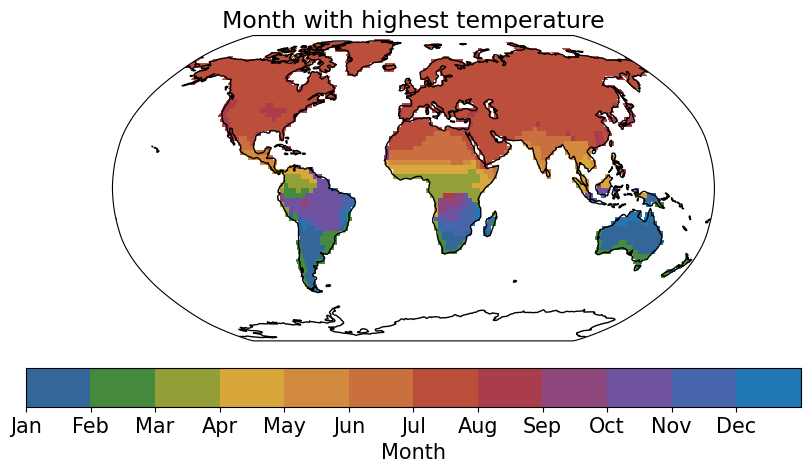

In [24]:
# plotting selected months 
idx_month = np.load(RESULTS_DIR / 'tas_hottest_month.npy')

peak_temperature_months_df = xr.DataArray(data = idx_month, 
                                          dims = ['coords'],
                                          coords = {'coords': ds_coords}).unstack('coords').sortby('lon')

fig = plt.figure(figsize = (10,5))

gs  = GridSpec(5, 2, figure=fig)

axes = []

ax = fig.add_subplot(gs[:4, :], projection=ccrs.Robinson())
cbar_ax = fig.add_subplot(gs[4:, :])

ax.set_global()
ax.coastlines(edgecolor = 'lightgrey')
peak_temperature_months_df.plot(ax=ax, 
            transform = ccrs.PlateCarree(),
            cmap = cmap_months,
            levels  = [0,1,2,3,4,5,6,7,8,9,10,11,12],
            add_colorbar = False,
            extend = 'neither',
            alpha = None)
ax.set_title('Month with highest temperature', fontsize = fontsize_large)
plot_1D_colorbar(cbar_ax, cmap_months, np.arange(13), month_names, indicator_label = 'Month')
Path(GRAPHICS_PAPER_APPENDIX_DIR).mkdir(parents=True, exist_ok=True)
plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'highest_temperature_by_month.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()
